<h1> <center>🍿 Movie Recommendation Systems Using Content-Based Filtering and Collaborative Filtering</center> </h1>

<p><center>Author: Lærke Brædder</center></p>

***

<div style="width:100%;text-align: center;"> <img align=middle src="https://editor.analyticsvidhya.com/uploads/76889recommender-system-for-movie-recommendation.jpg" alt="Movie" style="height:60%;margin-top:3rem;"> </div>

## Introduction

Recommender systems are an integral part of much of our online activity. They have been around for decades, but have recently become more prominent due to the rise in popularity and availability of online entertainment such as streaming platforms. The goal of a recommender system is to suggest appropriate items to a user based on how various features of the item match the user's preferences. The systems aim to predict the probability of a user buying/liking the item.

In this notebook we will be going over two different types of recommender system. The first type is relies on a content-based filtering approach, and the secon type relies on a collaborative filtering approach. 

All in all, we will create 4 different types of recommenders.

1. The Content-Based Recommender
2. The Item-Based Collaborative Filtering Recommender
3. The User-Based Collaborative Filtering Recommender
4. The Model-Based Collaborative Filtering Recommender

Each of these recommenders, and how they were created, will be presented in thorough detail throughout the notebook. If you are looking for the quick and clean version, the collected finalized code for each recommender can be found in the last section of each chapter named "Functionalizing the xxx-Based Recommender".

***

<font color = 'blue'>
Content:

    
1. [**Content-Based Filtering**](#1)
    * 1.1 [Generating TF-IDF Matrix](#2)
        * 1.1.1 [Loading the data](#3)
        * 1.1.2 [TF-IDF Vectorizer](#4)
    * 1.2 [Cosine Similarity Matrix](#5)
    * 1.3 [Making Suggestions Based on Similarities](#6)
    * 1.4 [Functionalizing the Content-Based Recommender](#7)
    
1. [**Collaborative Filtering**](#8)
     * 2.1 [Item-Based Collaborative Filtering](#9)
        * 2.1.1 [Data Preprocessing](#10)
        * 2.1.2 [Creating a User Movie Df](#11)
        * 2.1.3 [Item-Based Movie Suggestions](#12)
        * 2.1.3 [Functionalizing the Item-Based Recommender](#13)
     * 2.2 [User-Based Collaborative Filtering](#14)
        * 2.2.1 [Data Preprocessing](#15)
        * 2.2.2 [Determining The Movies that Our Random User Has Watched To Make Suggestions](#16)
        * 2.2.3 [Accessing Data and IDs of Other Users Watching the Same Movies](#17)
        * 2.2.4 [Identifying Other Users Who Behave Similarily to Our User of Interest](#18)
        * 2.2.5 [Calculating the Weighted Average Recommendation Score](#19)
        * 2.2.6 [Functionalizing the User-Based Recommender](#20)
     * 2.3 [Model-Based Collaborative Filtering - Matrix Factorization](#21)
        * 2.3.1 [Data Preprocessing](#22)
        * 2.3.2 [Modelling](#23)
        * 2.3.3 [Model Tuning](#24)
        * 2.3.4 [Final Model and Prediction](#25)
        * 2.3.5 [Functionalizing the Model-Based Recommender](#25)
    

# 1. Content-Based Filtering

With content-based filtering, we create mathematical representations (vectors) of text data.

From the movie data, we create a TF-IDF matrix and a cosine similarity matrix and recommend movies to the user based on similarities.

For this task, we are goint to need the Euclidian distance, which finds the distance between two vectors.

The cosine similarity is a metric, which focuses on the similarity of two vectors.

In [2]:
# Importing packages

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.expand_frame_repr', False)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import numpy as np

## 1.1. Generating TF-IDF Matrix

Here we make a recommendation system based on movie overviews - a column in the data which contains a short text description of each movie.

### 1.1.1. Loading the data

In [ ]:
# Loading the movies metadata
# df2 = pd.read_csv("the_movies_dataset/movies_metadata.csv", sep = ";", encoding = 'unicode_escape', low_memory=False) 
df2 = pd.read_csv("the_movies_dataset/movies_metadata.csv", encoding = 'unicode_escape', low_memory=False)

# Inspecting the dataframe
df2.head(3)

In [54]:
df2["overview"].head(3)

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
Name: overview, dtype: object

### 1.1.2. IF-IDF vectorizer

- TF(t) is the term frequency of a term t in a given document.
- IDF(t) is the inverse document frequency, i.e. the number of documents with t term + 1 (xxx?).
- TF-IDF is the product of the above two.
- L2 is the normalization to TF-IDF values.

In [55]:
# We start by defining our vectorizer
tfidf = TfidfVectorizer(stop_words = 'english')

# Now, we remove NAs from the overview column in out dataset
df2['overview'] = df2['overview'].fillna('')

# and fit the vectorizer to the data
tfidf_matrix = tfidf.fit_transform(df2['overview'])
tfidf_matrix.shape

(45466, 77492)

## 1.2. Cosine Similarity Matrix

In [56]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

cosine_sim.shape

(45466, 45466)

In [57]:
cosine_sim[1]

array([0.01503245, 1.        , 0.04683251, ..., 0.        , 0.02181715,
       0.00929001])

## 1.3. Making Suggestions Based on Similarity

In [58]:
# Indexing the movies
indices = pd.Series(df2.index, index=df2['title'])
indices = indices[~indices.index.duplicated(keep='last')]

print(indices.shape)

print(indices[:10])

(42278,)
title
Toy Story                       0
Jumanji                         1
Grumpier Old Men                2
Waiting to Exhale               3
Father of the Bride Part II     4
Tom and Huck                    7
Sudden Death                    8
GoldenEye                       9
The American President         10
Dracula: Dead and Loving It    11
dtype: int64


In [59]:
## Little example for inspection

# Saving the index of a specific movie as an object
jumanji_index = indices["Jumanji"]

# and getting the cosine similarities between Jumanji and other movies
cosine_sim[jumanji_index]

array([0.01503245, 1.        , 0.04683251, ..., 0.        , 0.02181715,
       0.00929001])

In [60]:
# Creating a dataframe containing the cosine similarities for all of the movies in the data
similarity_scores = pd.DataFrame(cosine_sim[jumanji_index], columns=["score"])

# Showing the 10 movies that have the closest cosine similarity to our chosen movie (from most similar to least similar)
jumanji_indices = similarity_scores.sort_values("score", ascending=False)[1:11].index

df2[['title', 'id']].iloc[jumanji_indices]

,title,id
21633,Table No. 21,157129
45253,Quiz,96823
41573,Snowed Under,217672
35509,The Mend,253258
44376,Liar Game: Reborn,133977
17223,The Dark Angel,120977
8801,Quintet,45169
6166,Brainscan,14237
30981,Turkey Shoot,301730
9503,Word Wars,28105


## 1.4. Now, let's make it into a function

In [4]:
def create_cosine_sim(dataframe):
    # Vectorizing
    tfidf = TfidfVectorizer(stop_words = 'english')
    dataframe['overview'] = dataframe['overview'].fillna('')
    tfidf_matrix = tfidf.fit_transform(dataframe['overview'])

    # Creating the similarity matrix
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

    return cosine_sim


def content_based_recommender(title, dataframe, n_recommendations):
    
    # First, we write the code that generates indicies for all of the movie titles
    indices = pd.Series(dataframe.index, index=dataframe['title'])
    indices = indices[~indices.index.duplicated(keep='last')]

    # Now, we can capture the index of our given movie title
    movie_index = indices[title]

    # Calculating similarity scores by title
    similarity_scores = pd.DataFrame(cosine_sim[movie_index], columns=["score"])

    # Showing the to n most similar movies (excluding the movie itself)
    movie_indices = similarity_scores.sort_values("score", ascending=False)[1:(n_recommendations+1)].index
    
    return dataframe[['title', 'id']].iloc[movie_indices]

In [5]:
cosine_sim = create_cosine_sim(df2) # This could be nested inside the recommender, but it takes a long time to run, so let's put it here

# Trying it out
content_based_recommender("The Lion King", df2, 10)

# Just by eyeballing, these results look pretty promising. From the titles we can guess, that the movie descriptions
# will probably contain words that are similar to those from The Lion King overview. 

,title,id
34682,How the Lion Cub and the Turtle Sang a Song,273126
9353,The Lion King 1Â½,11430
9115,The Lion King 2: Simba's Pride,9732
42829,Prey,400610
25654,Fearless Fagan,241804
17041,African Cats,57586
27933,"MassaÃ¯, les guerriers de la pluie",74684
6094,Born Free,15347
37409,Sour Grape,357959
3203,The Waiting Game,210307


## 1.5. Evaluating the Recommendations

Since this is not a model-based machine learning method, we cannot directly evaluate the accuracy of our recommendation system. However, we can use the ratings data to check if the users who rated, say Jumanji, highly did indeed also rate the recommended movies highly.



In [8]:
def rating_df_plot():
    # Loading the ratings data
    rating = pd.read_csv('movielens/rating.csv')

    # Renaming the id col to match the one in the recommendations output
    rating = rating.rename(columns={"movieId" : "id"})

    # Matching the datatype of the recommendation df to avoid merging issues
    rating["id"] = rating["id"].astype("str")

    # Selecting a subset of 10 random users
    ids = np.random.choice(rating["userId"], size=10, replace=False)
    rating_sample = pd.DataFrame(rating.loc[rating["userId"].isin(ids)])

    return rating_sample, ids




def create_df_for_plotting(movielist, dataframe): # the recommender arg takes the name of the recommender functions
    plot_df = pd.DataFrame()

    for movie in movielist:
        movie_df = content_based_recommender(movie, dataframe, dataframe.shape[0])
        movie_df['rec_number'] = range(1, len(movie_df) + 1)
        movie_df = movie_df.merge(rating_sample)
        movie_df = pd.DataFrame(movie_df.loc[movie_df["userId"].isin(ids)])
        movie_df['movie'] = movie
    
        plot_df = pd.concat([plot_df, movie_df])
    
    return plot_df
 

In [9]:
rating_sample, ids = rating_df_plot()

plot_df_cb = create_df_for_plotting(["Toy Story", "Jumanji", "The Lion King", "Finding Nemo"], df2)   

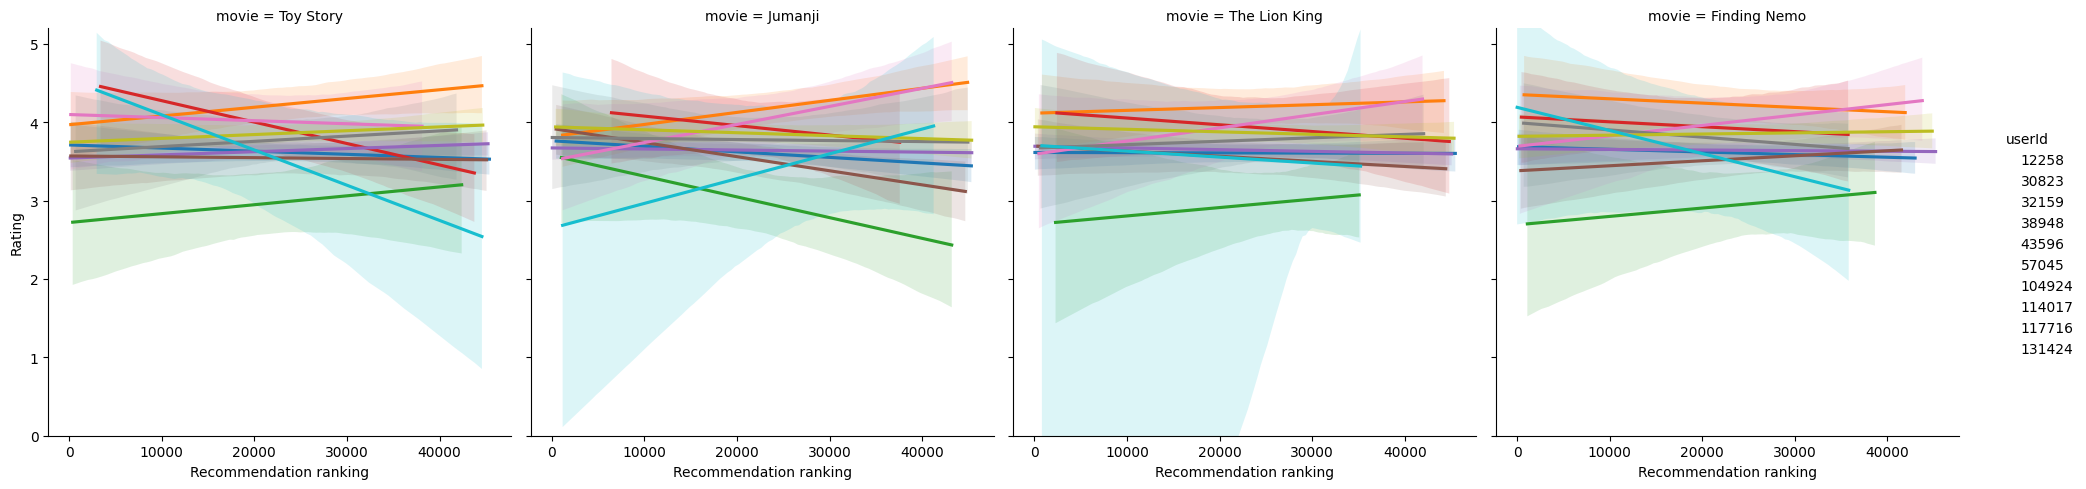

In [10]:
def plot_ratings(data):
    import seaborn as sns

    g = sns.lmplot(data=data,
                   x= "rec_number", y= "rating", 
                   hue="userId", col="movie",
                   scatter_kws={"s": 0})
    g.set(ylim=(0, 5.2),
          xlabel = "Recommendation ranking",
          ylabel = 'Rating')

    return g


plot_ratings(plot_df_cb)

# 2. Collaborative Filtering

## 2.1. Item-Based Collaborative Filtering

For this approach, recommendations are made based on item similarity. For example, if we liked Finding Nemo, then we might want to be recommended other movies that show the same liking structure, or that have the same director, cast, etc.

### 2.1.1. Data Preprocessing

In [12]:
# Setting column display limit for dataframes (for your viewing pleasure)
pd.set_option('display.max_columns', 20)

# Loading the data
movie = pd.read_csv('movielens/movie.csv')
rating = pd.read_csv('movielens/rating.csv')
df3 = movie.merge(rating, how="left", on="movieId")
df3.head(3)

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.0,4.0,1999-12-11 13:36:47
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,6.0,5.0,1997-03-13 17:50:52
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8.0,4.0,1996-06-05 13:37:51


In [ ]:
# This is a pretty large dataset; We have 20000797 rows and 6 columns, and we don't want to use all of them. Let's start by taking just a sample from this data.
# df3 = df3.sample(frac = .50) # frac refers to the fraction of the dataset that we want to keep.

### 2.1.2. Creating a user movie df

In [ ]:
# Number of movies in the dataset
df3["title"].nunique()

27262

In [ ]:
# rating count of each movies
df3["title"].value_counts().head()

title
Pulp Fiction (1994)                 67310
Forrest Gump (1994)                 66172
Shawshank Redemption, The (1994)    63366
Silence of the Lambs, The (1991)    63299
Jurassic Park (1993)                59715
Name: count, dtype: int64

In [ ]:
# Making a rating count dataframe
rating_counts = pd.DataFrame(df3["title"].value_counts()).reset_index()

In [ ]:
# Now, we want to filter out rare movies (i.e. movies that have 10000 ratings or less)
rare_movies = rating_counts.loc[rating_counts["count"] <= 10000, "title"]

# Taking out rare movies from our dataframe
common_movies = df3[~df3["title"].isin(rare_movies)]

In [ ]:
# all ratings
print(common_movies.shape)

# we have 462 movies now
print(common_movies["title"].nunique())

(9050403, 6)
462


In [ ]:
# let's pivot it
user_movie_df = common_movies.pivot_table(index=["userId"], columns=["title"], values="rating")

In [ ]:
print(user_movie_df.shape)
user_movie_df.head(5)

(137658, 462)


title,10 Things I Hate About You (1999),12 Angry Men (1957),2001: A Space Odyssey (1968),28 Days Later (2002),300 (2007),A.I. Artificial Intelligence (2001),"Abyss, The (1989)",Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),Addams Family Values (1993),...,Wild Wild West (1999),William Shakespeare's Romeo + Juliet (1996),Willy Wonka & the Chocolate Factory (1971),Witness (1985),"Wizard of Oz, The (1939)","X-Files: Fight the Future, The (1998)",X-Men (2000),X2: X-Men United (2003),You've Got Mail (1998),Young Frankenstein (1974)
userId,,,,,,,,,,,,,,,,,,,,,
1.0,NaN,NaN,3.5,3.5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.5,NaN,NaN,4.0,NaN,4.0
2.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,NaN,NaN,5.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,5.0,4.0,4.0,5.0,NaN,NaN,NaN,5.0
4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2.1.3. Item-Based Movie Suggestions

In [ ]:
# Now, we choose a movie, say Pulp Fiction
movie_name = "Pulp Fiction (1994)"

movie_name = user_movie_df[movie_name]

user_movie_df.corrwith(movie_name).sort_values(ascending=False).head(10)

title
Pulp Fiction (1994)            1.000000
Reservoir Dogs (1992)          0.510497
Kill Bill: Vol. 1 (2003)       0.447371
Kill Bill: Vol. 2 (2004)       0.426959
Natural Born Killers (1994)    0.355001
Sin City (2005)                0.348965
Trainspotting (1996)           0.348773
Goodfellas (1990)              0.343675
Fight Club (1999)              0.328060
True Romance (1993)            0.323993
dtype: float64

### 2.1.4. Making it into a function

In [15]:
def create_user_movie_df():
    movie = pd.read_csv('movielens/movie.csv')
    rating = pd.read_csv('movielens/rating.csv')
    df = movie.merge(rating, how="left", on="movieId")
    
    rating_counts = pd.DataFrame(df["title"].value_counts()).reset_index()
    rare_movies = rating_counts.loc[rating_counts["count"] <= 10000, "title"]
    common_movies = df[~df["title"].isin(rare_movies)]
    user_movie_df = common_movies.pivot_table(index=["userId"], columns=["title"], values="rating")
    
    return user_movie_df


def item_based_recommender(movie_name, user_movie_df, n_recommendations):
    movie_name = user_movie_df[movie_name]
    output = pd.DataFrame(user_movie_df.corrwith(movie_name).sort_values(ascending=False).head(n_recommendations))
    output = output.reset_index().rename(columns={0 : "correlation"})

    return output

In [13]:
user_movie_df = create_user_movie_df()

item_based_recommender("Fight Club (1999)", user_movie_df, 10)

,title,correlation
0,Fight Club (1999),1.000000
1,Seven (a.k.a. Se7en) (1995),0.349805
2,Pulp Fiction (1994),0.328060
3,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),0.327986
4,Snatch (2000),0.326288
5,American History X (1998),0.326111
6,Trainspotting (1996),0.322369
7,"Lock, Stock & Two Smoking Barrels (1998)",0.319509
8,Memento (2000),0.308780
9,Donnie Darko (2001),0.305932


In [58]:
# this function helps to find the movie names
def check_film(keyword, user_movie_df):
    return [col for col in user_movie_df.columns if keyword in col]


check_film("Star", user_movie_df)

['Star Trek II: The Wrath of Khan (1982)',
 'Star Trek III: The Search for Spock (1984)',
 'Star Trek IV: The Voyage Home (1986)',
 'Star Trek VI: The Undiscovered Country (1991)',
 'Star Trek: First Contact (1996)',
 'Star Trek: Generations (1994)',
 'Star Wars: Episode I - The Phantom Menace (1999)',
 'Star Wars: Episode II - Attack of the Clones (2002)',
 'Star Wars: Episode III - Revenge of the Sith (2005)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Star Wars: Episode V - The Empire Strikes Back (1980)',
 'Star Wars: Episode VI - Return of the Jedi (1983)',
 'Stargate (1994)',
 'Starship Troopers (1997)']

### 2.1.5. Evaluating the Recommendations

In [16]:
# Selecting a subset of 10 random users
ids = np.random.choice(rating["userId"], size=10, replace=False)
rating_sample = pd.DataFrame(rating.loc[rating["userId"].isin(ids)])
rating_sample.shape


(2620, 4)

In [17]:
rating_sample.head()

,userId,movieId,rating,timestamp
2178254,14745,6,4.5,2006-09-09 18:43:30
2178255,14745,10,4.0,2006-09-09 18:42:42
2178256,14745,11,3.5,2005-09-28 13:55:34
2178257,14745,18,4.0,2005-09-28 13:49:33
2178258,14745,21,3.5,2005-09-28 13:47:26


In [18]:
def create_df_for_plotting_2(movielist, dataframe):
    plot_df = pd.DataFrame()

    for movie in movielist:
        movie_df = item_based_recommender(movie, user_movie_df, dataframe.shape[0])
        movie_df['rec_number'] = range(1, len(movie_df) + 1)
        movie_df = pd.merge(movie_df, dataframe[['title', 'movieId']], how = 'left', on = 'title').drop_duplicates()
        movie_df = movie_df.merge(rating_sample)
        movie_df = pd.DataFrame(movie_df.loc[movie_df["userId"].isin(ids)])
        movie_df['movie'] = movie

        plot_df = pd.concat([plot_df, movie_df])

    return plot_df

In [19]:
plot_df_ib = create_df_for_plotting_2(["Star Wars: Episode IV - A New Hope (1977)", "Fight Club (1999)", "Toy Story (1995)", "Princess Bride, The (1987)"], df3)   

In [20]:
plot_df_ib

,title,correlation,rec_number,movieId,userId,rating,timestamp,movie
0,Star Wars: Episode IV - A New Hope (1977),1.000000,1,260,14745,4.0,2005-09-28 02:22:22,Star Wars: Episode IV - A New Hope (1977)
1,Star Wars: Episode IV - A New Hope (1977),1.000000,1,260,20387,5.0,1997-04-02 09:54:33,Star Wars: Episode IV - A New Hope (1977)
2,Star Wars: Episode IV - A New Hope (1977),1.000000,1,260,27141,4.5,2008-11-06 08:43:05,Star Wars: Episode IV - A New Hope (1977)
3,Star Wars: Episode IV - A New Hope (1977),1.000000,1,260,63905,4.5,2008-11-06 07:11:15,Star Wars: Episode IV - A New Hope (1977)
4,Star Wars: Episode IV - A New Hope (1977),1.000000,1,260,89209,5.0,2005-03-02 18:53:11,Star Wars: Episode IV - A New Hope (1977)
...,...,...,...,...,...,...,...,...
1107,Alien³ (a.k.a. Alien 3) (1992),0.024470,461,1320,33748,4.0,2001-08-04 20:59:45,"Princess Bride, The (1987)"
1108,Alien³ (a.k.a. Alien 3) (1992),0.024470,461,1320,89209,4.0,2005-03-02 18:47:03,"Princess Bride, The (1987)"
1109,Alien³ (a.k.a. Alien 3) (1992),0.024470,461,1320,129839,3.0,1997-03-25 11:04:47,"Princess Bride, The (1987)"
1110,Eyes Wide Shut (1999),-0.010677,462,2712,27141,3.0,2008-11-06 13:59:16,"Princess Bride, The (1987)"


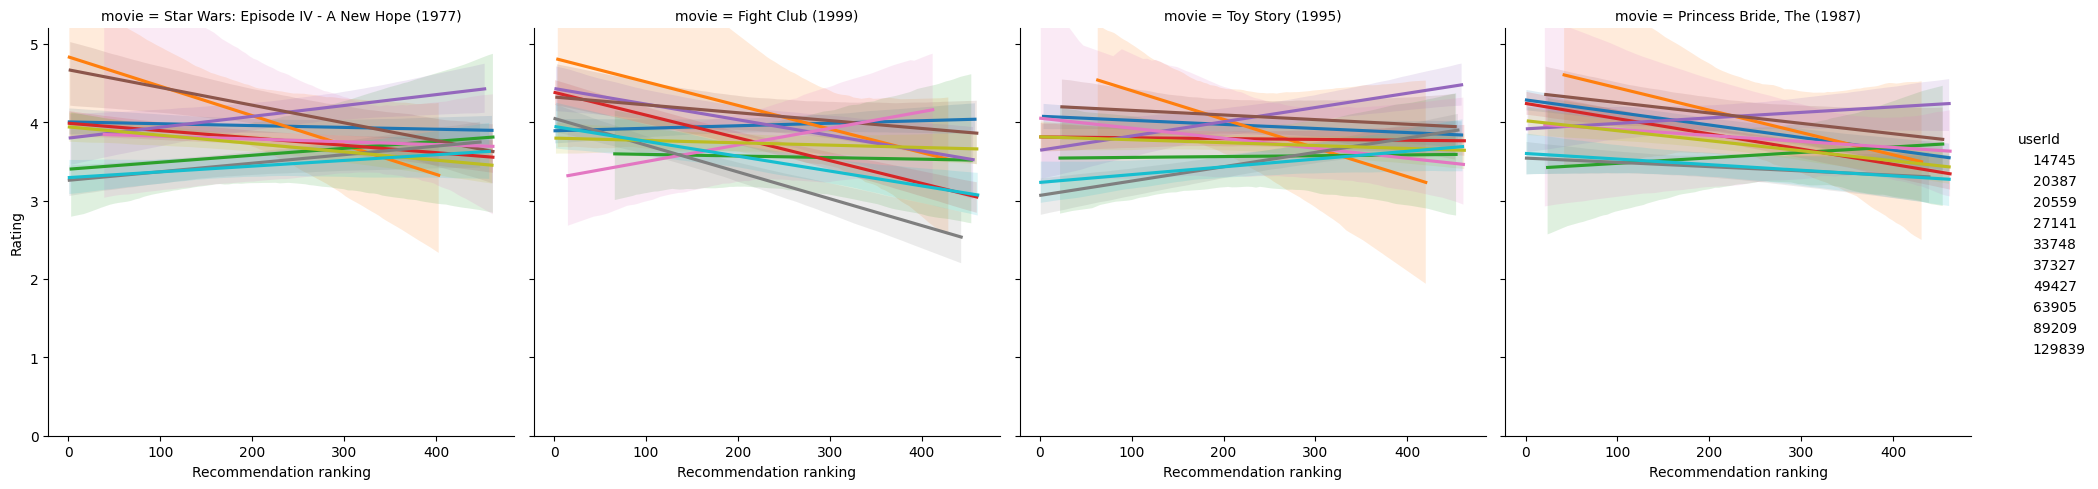

In [23]:
plot_ratings(plot_df_ib)

## 2.2. User-Based Collaborative Filtering

For this approach, movie recommendations are made based on similarities between different users.

In section 2.2. we will be:

1) Preparing the dataset
2) Determining which movies the user of interest has already watched
3) Accessing the data from other users who watched the same movies
4) Identifying other users, who display similar behaviour to our user of interest, to suggest
5) Calculating the weighted average recommendation score


### 2.2.1. Data preprocessing
We will still be using the user_movie_df matrix that we defined in previous sections.

In [ ]:
user_movie_df.head(3)

In [142]:
# We begin by defining a random user in the dataset
random_user = int(pd.Series(user_movie_df.index).sample(1, random_state=35).values)

random_users

[8362, 134438, 83269, 15007]

### 2.2.2. Determining the movies that our random user has watched in order to make a suggestion

In [ ]:
# we selected the random_user's movie here
random_user_df = user_movie_df[user_movie_df.index == random_user]
random_user_df # This is a df containing the random user's rating for 
# ... all 462 movies in the data. Many of them have NaN values, because
# ... they have not been rated by this user.

title,10 Things I Hate About You (1999),12 Angry Men (1957),2001: A Space Odyssey (1968),28 Days Later (2002),300 (2007),A.I. Artificial Intelligence (2001),"Abyss, The (1989)",Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),Addams Family Values (1993),...,Wild Wild West (1999),William Shakespeare's Romeo + Juliet (1996),Willy Wonka & the Chocolate Factory (1971),Witness (1985),"Wizard of Oz, The (1939)","X-Files: Fight the Future, The (1998)",X-Men (2000),X2: X-Men United (2003),You've Got Mail (1998),Young Frankenstein (1974)
userId,,,,,,,,,,,,,,,,,,,,,
8362.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Taking out all NaN to make a list of the movies watched by this user
movies_watched = random_user_df.columns[random_user_df.notna().any()].tolist()

In [ ]:
# how many movies did he watch
len(movies_watched)

50

### 2.2.3. Accessing the data and IDs of other users watching the same movies

In [ ]:
# random user's movies 
movies_watched_df = user_movie_df[movies_watched]
movies_watched_df.head()

title,Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),Addams Family Values (1993),Aladdin (1992),Apollo 13 (1995),Batman (1989),"Birdcage, The (1996)",City Slickers II: The Legend of Curly's Gold (1994),Clear and Present Danger (1994),Clerks (1994),...,Sleepless in Seattle (1993),"Specialist, The (1994)",Star Trek: Generations (1994),Stargate (1994),Taxi Driver (1976),Terminator 2: Judgment Day (1991),Tombstone (1993),Twelve Monkeys (a.k.a. 12 Monkeys) (1995),"Usual Suspects, The (1995)",Waterworld (1995)
userId,,,,,,,,,,,,,,,,,,,,,
1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,3.5,NaN,3.5,3.5,NaN
2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN
3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,5.0,5.0,NaN,4.0,NaN,4.0,5.0,NaN
4.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,4.0,NaN,1.0,NaN,NaN
5.0,NaN,NaN,NaN,5.0,5.0,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,5.0,NaN,NaN,NaN,NaN


In [ ]:
# Number of people who watched at least one movie in common with random user. 137658 people watched at least on movie, common movies count 191
movies_watched_df.shape

(137658, 50)

This shows us that there are lots of people who have at least one movie in common, however, we are going to need a threshold here. Now, we set a threshold for users who have at least xxx movies in common.

In [ ]:
# user_movie_count indicates how many movies each user watched
# notnull gives us binary output (1 or 0) if we don't do that, the ratings count, like 3.0 + 4.0 = 7.0
user_movie_count = movies_watched_df.T.notnull().sum()

# moving user_movie_count in the columns
user_movie_count = user_movie_count.reset_index()

user_movie_count.columns = ["userId", "movie_count"]
user_movie_count.head()

,userId,movie_count
0,1.0,12
1,2.0,3
2,3.0,12
3,4.0,10
4,5.0,18


In [ ]:
# 40 treshold in common movies
user_movie_count[user_movie_count["movie_count"] > 40].sort_values("movie_count", ascending=False)

,userId,movie_count
37016,37253.0,50
59785,60159.0,50
87180,87718.0,50
92547,93113.0,50
39914,40167.0,50
...,...,...
44215,44492.0,41
74157,74611.0,41
44912,45194.0,41
74022,74476.0,41


In [ ]:
# Now, we can check to see how many people have watched the same movies as out random user (he watched 50 movies )
# there is one person watching the same movies
user_movie_count[user_movie_count["movie_count"] == 50].count()

userId         67
movie_count    67
dtype: int64

In [ ]:
# let's bring users id watching the same movies
users_same_movies = user_movie_count[user_movie_count["movie_count"] > 40]["userId"]
users_same_movies.head()

users_same_movies.count()

2565

### 2.2.4. Identifying other users who behave similarily to our user of interest

In order to do this, we have three steps to go through:
1) aggregating the data from our random user and other users
2) creating a correlation dataframe
3) finding the most similar users (Top Users)

In [ ]:
final_df = pd.concat([movies_watched_df[movies_watched_df.index.isin(users_same_movies)],
                      random_user_df[movies_watched]])

print(final_df.shape)
final_df.head()

(2566, 50)


title,Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),Addams Family Values (1993),Aladdin (1992),Apollo 13 (1995),Batman (1989),"Birdcage, The (1996)",City Slickers II: The Legend of Curly's Gold (1994),Clear and Present Danger (1994),Clerks (1994),...,Sleepless in Seattle (1993),"Specialist, The (1994)",Star Trek: Generations (1994),Stargate (1994),Taxi Driver (1976),Terminator 2: Judgment Day (1991),Tombstone (1993),Twelve Monkeys (a.k.a. 12 Monkeys) (1995),"Usual Suspects, The (1995)",Waterworld (1995)
userId,,,,,,,,,,,,,,,,,,,,,
29.0,3.0,3.0,3.0,4.0,4.0,4.0,NaN,4.0,3.0,NaN,...,NaN,4.0,3.0,3.0,NaN,4.0,4.0,3.0,4.0,3.0
91.0,2.5,2.0,2.5,NaN,3.5,4.0,3.5,3.0,3.0,1.5,...,3.5,NaN,3.5,4.0,NaN,2.5,4.5,4.0,3.5,1.5
116.0,3.5,2.5,2.0,3.0,3.0,4.5,2.5,2.0,1.5,3.5,...,NaN,2.5,2.0,3.5,4.0,4.0,4.0,4.0,4.5,2.0
156.0,3.0,NaN,3.0,NaN,5.0,4.0,4.0,3.0,5.0,NaN,...,4.0,4.0,3.0,4.0,4.0,5.0,4.0,5.0,5.0,3.0
294.0,2.5,1.0,3.5,4.0,5.0,3.5,3.0,1.5,2.5,NaN,...,3.5,3.0,4.0,NaN,4.5,NaN,5.0,4.0,NaN,1.5


In [ ]:
# Reshaping the matrix

final_df.T.corr() # Placing all users in the columns
# And tidying up
corr_df = final_df.T.corr().unstack().sort_values().drop_duplicates()
corr_df = pd.DataFrame(corr_df, columns=["corr"])
corr_df.index.names = ['user_id_1', 'user_id_2']
corr_df = corr_df.reset_index()

corr_df.head()

,user_id_1,user_id_2,corr
0,40505.0,67756.0,-0.751181
1,18893.0,59226.0,-0.703250
2,67756.0,27406.0,-0.695150
3,26386.0,27239.0,-0.684906
4,61858.0,124395.0,-0.680414


In [ ]:
# Displaying users with =>65% correlation with our random user
top_users = corr_df[(corr_df["user_id_1"] == random_user) & (corr_df["corr"] >= 0.65)][
    ["user_id_2", "corr"]].reset_index(drop=True)

top_users = top_users.sort_values(by='corr', ascending=False)
top_users.rename(columns={"user_id_2": "userId"}, inplace=True)
top_users

,userId,corr
45,8362.0,1.000000
44,2937.0,0.749294
43,78109.0,0.736563
42,8608.0,0.731655
41,78755.0,0.729519
40,101171.0,0.714929
39,101171.0,0.714929
38,18611.0,0.708948
37,82981.0,0.699751
36,53998.0,0.699228


In [ ]:
# Now, we take this new table and merge it with the user ratings
rating = pd.read_csv('movielens/rating.csv')
top_users_ratings = top_users.merge(rating[["userId", "movieId", "rating"]], how='inner')

In [ ]:
# And we remove our random user of interest from the correlation table
top_users_ratings = top_users_ratings[top_users_ratings["userId"] != random_user]

top_users_ratings.head()

,userId,corr,movieId,rating
51,2937.0,0.749294,1,4.0
52,2937.0,0.749294,6,4.0
53,2937.0,0.749294,7,3.0
54,2937.0,0.749294,10,3.0
55,2937.0,0.749294,11,4.0


Here we encounter the problem that there are two levels in the data, namely correlating and rating. Some users will have high correlation with our random user of interest, but high rating, etc. So, which one of these levels is it most important to consider? 

In order to figure that out, we make a weighting based on the two levels.

### 2.2.5. Calculating the weighted average recommendation score

Now, we create a single score by considering both correlation (i.e. the impact of the users that behave similarly to our user of interest) and rating simultaneously.

In [ ]:
# Calculation of weighted_rating
top_users_ratings['weighted_rating'] = top_users_ratings['corr'] * top_users_ratings['rating']
top_users_ratings.head()

,userId,corr,movieId,rating,weighted_rating
51,2937.0,0.749294,1,4.0,2.997175
52,2937.0,0.749294,6,4.0,2.997175
53,2937.0,0.749294,7,3.0,2.247882
54,2937.0,0.749294,10,3.0,2.247882
55,2937.0,0.749294,11,4.0,2.997175


In [ ]:
# Here we have the issue that there are many ratings for each movie. Therefore we need to group
recommendation_df = top_users_ratings.groupby('movieId').agg({"weighted_rating": "mean"})

recommendation_df = recommendation_df.reset_index()

print(recommendation_df[["movieId"]].nunique())
recommendation_df.head()

movieId    8071
dtype: int64


,movieId,weighted_rating
0,1,2.778496
1,2,2.109489
2,3,1.746772
3,4,1.886453
4,5,1.769812


This results in a total of 8071 recommended movies, so now we will recommend just the ones that have a weighted score above 3.5

In [ ]:
movies_to_be_recommend = recommendation_df[recommendation_df["weighted_rating"] > 3.5].sort_values("weighted_rating", ascending=False)

# list of movies to recommend
movie = pd.read_csv('movielens/movie.csv')
movies_to_be_recommend.merge(movie[["movieId", "title"]])

,movieId,weighted_rating,title
0,116,3.746469,Anne Frank Remembered (1995)
1,27002,3.574647,From the Earth to the Moon (1998)
2,3038,3.544738,"Face in the Crowd, A (1957)"
3,7234,3.544738,"Strada, La (1954)"
4,78986,3.544738,Salvador (Puig Antich) (2006)
5,214,3.509063,Before the Rain (Pred dozhdot) (1994)


### 2.2.6. Functionalizing the User-Based Recommender

In [1]:
def user_based_recommender(random_user):
    
    # Importing libraries
    import pickle
    import pandas as pd

    # Preparing the data
    #user_movie_df = create_user_movie_df() # Using the function we made previously.
    
    rating = pd.read_csv('movielens/rating.csv')
    movie = pd.read_csv('movielens/movie.csv')

    output = pd.DataFrame()
        
    # Determining the movies that a random user has watched
    random_user_df = user_movie_df[user_movie_df.index == random_user]
    movies_watched = random_user_df.columns[random_user_df.notna().any()].tolist()
    movies_watched_df = user_movie_df[movies_watched]
    
    # Accessing the data and IDs of other users watching the same movies
    user_movie_count = movies_watched_df.T.notnull().sum().reset_index()
    user_movie_count.columns = ["userId", "movie_count"]
    user_movie_count[user_movie_count["movie_count"] > 20].sort_values("movie_count", ascending=False) 
    users_same_movies = user_movie_count[user_movie_count["movie_count"] > 40]["userId"]

    # Identifying other users with the same behaviour
    ## Creating and reshaping the user matrix
    final_df = pd.concat([movies_watched_df[movies_watched_df.index.isin(users_same_movies)],
                      random_user_df[movies_watched]])
    corr_df = final_df.T.corr().unstack().sort_values().drop_duplicates()
    corr_df = pd.DataFrame(corr_df, columns=["corr"])
    corr_df.index.names = ['user_id_1', 'user_id_2']
    corr_df = corr_df.reset_index()

    ## Finding users with =>65% correlation with the random user
    top_users = corr_df[(corr_df["user_id_1"] == random_user) & (corr_df["corr"] >= 0.65)][
        ["user_id_2", "corr"]].reset_index(drop=True)
    top_users = top_users.sort_values(by='corr', ascending=False)
    top_users.rename(columns={"user_id_2": "userId"}, inplace=True) 

    # Merging with the rating data
    top_users_ratings = top_users.merge(rating[["userId", "movieId", "rating"]], how='inner')
    top_users_ratings = top_users_ratings[top_users_ratings["userId"] != random_user]

    # Calculating the weighted average recommendation score
    top_users_ratings['weighted_rating'] = top_users_ratings['corr'] * top_users_ratings['rating']
    recommendation_df = top_users_ratings.groupby('movieId').agg({"weighted_rating": "mean"}).reset_index()
        
    # For the purpose of plotting like in the last two systems, we want to get all of the recommendations including the bad ones. Otherwise we might filter above 3.5
    #movies_to_be_recommend = recommendation_df[recommendation_df["weighted_rating"] > 3.5].sort_values("weighted_rating", ascending=False)
    movies_to_be_recommend = recommendation_df[recommendation_df["weighted_rating"] > 0].sort_values("weighted_rating", ascending=False)

    movies_to_be_recommend = pd.DataFrame(movies_to_be_recommend.merge(movie[["movieId", "title"]]))

    movies_to_be_recommend['rec_number'] = range(1, len(movies_to_be_recommend) + 1)
    movies_to_be_recommend["user"] = random_user

    output = pd.concat([output, movies_to_be_recommend])
    
    return output


### 2.2.7. Evaluating Recommendations
NB: This part is not working!!

In [5]:
# Preparing the data
user_movie_df = create_user_movie_df() # Using the function we made previously.

In [6]:
#random_user_list = [8362, 15007]
random_user_list = [8362]

ub_plot_df = pd.DataFrame()

for user in random_user_list:
    ub = user_based_recommender(user)
    ub_plot_df = pd.concat([ub_plot_df, ub])

In [8]:
# Selecting a subset of 10 random movies
rating = pd.read_csv('movielens/rating.csv')

ids = np.random.choice(rating["movieId"], size=10, replace=False)
rating_sample2 = pd.DataFrame(rating.loc[rating["movieId"].isin(ids)])

In [9]:
ub_plot_df_2 = ub_plot_df.merge(rating_sample2)
ub_plot_df_2 = pd.DataFrame(ub_plot_df_2.loc[ub_plot_df_2["movieId"].isin(ids)])
ub_plot_df_2


,movieId,weighted_rating,title,rec_number,user,userId,rating,timestamp
0,4973,2.989296,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",372,8362,11,3.5,2009-01-02 18:16:37
1,4973,2.989296,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",372,8362,18,5.0,2007-11-20 15:51:13
2,4973,2.989296,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",372,8362,25,4.0,2010-07-01 05:59:13
3,4973,2.989296,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",372,8362,35,5.0,2006-11-26 00:09:55
4,4973,2.989296,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",372,8362,45,4.0,2006-10-25 23:05:00
...,...,...,...,...,...,...,...,...
140914,2722,1.300035,Deep Blue Sea (1999),7377,8362,138429,2.0,2006-07-21 19:06:41
140915,2722,1.300035,Deep Blue Sea (1999),7377,8362,138460,3.5,2013-09-03 14:34:19
140916,2722,1.300035,Deep Blue Sea (1999),7377,8362,138464,3.0,2002-06-23 00:35:57
140917,2722,1.300035,Deep Blue Sea (1999),7377,8362,138472,3.5,2010-02-25 17:29:40


In [11]:
ub_plot_df_2['rating'].dtype


dtype('float64')

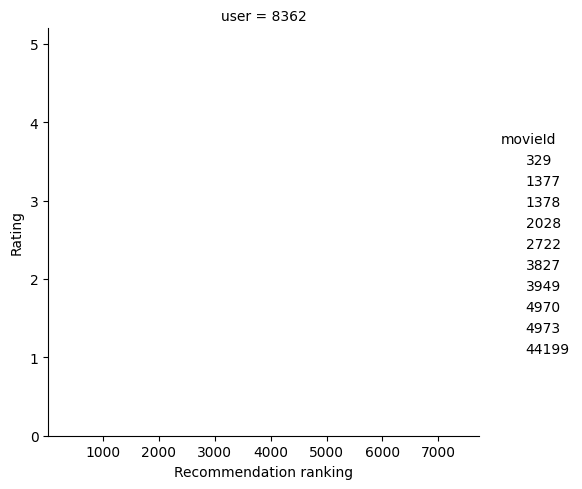

In [25]:
def plot_ratings(data):
    import seaborn as sns

    g = sns.lmplot(data=data,
                   x= "rec_number", y= "rating", 
                   hue="movieId", col="user",
                   scatter_kws={"s": 0})
    g.set(ylim=(0, 5.2),
          xlabel = "Recommendation ranking",
          ylabel = 'Rating')

    return g


plot_ratings(ub_plot_df_2)

## 2.3. Model-Based Collaborative Filtering - Matrix factorization

An assumption of matrix factorization is that there exist some latent features when a user likes a movie. The same type of hidden features are also present for the movies.

What are latent factors? they are a type of features in machine learning. In this case, they will be the underlying reasons as to why a given user likes a given movie, e.g. the genre of the movie, the director, the duration, the production company, the language in which the film was shot, etc.

Firstly, in order to fill in the gaps in our data, we find the weights of the latent features for users and movies over our data. We can then use these weights to make predictions for non-existent observations.

The approach here is to decompose the user-iten matrix, which we made previously, into 2 separate matrices of fewer dimensions. It is assumed that the transition between these different types of matrices occurs with latent factors, and we can thus assume the latent variables. Now, that we have filled in (assumed) missing observations, we can find the weights of the latent factors.

So, to summarize: We assume that our rating matrix is the dot product of two factor matrices - one separate matrix for user latent factors and one separate matrix for movie latent factors. Both users and movies are then considered to have weights (scores) for these latent features. We begin by finding weights on the data that we have, and then we fill out the gaps according to these weights.

#### Some Notes
* Matrix Factorization vs SVD is not the same

* SVD (Singular Value Decomposition) is a size reduction method.

* ALS --> Spark ALS for big data. Only difference ALS make some changes on p and q values.

"""


### About collaborative filtering

[1] (https://developers.google.com/machine-learning/recommendation/collaborative/basics):

For methods:

Collaborative fltering deals with some of the limitations of content-based filtering by taking into consideration not only similarities between items (cast, director, budget, etc.) but also similarities between users when providing recommendations. In this manner, models that use collaborative filtering can recommend a movie to user A based on the interests (ratings, for example) of a similar user B. Another advantage of collaborative filtering is, that the embeddings are learned automatically by the model, i.e. there is no need to hand-engineer the features as with content-based filtering. 

More specifically regarding our workflow (I think):

For our training data, we have a feedback matrix where each row represents a user and each column represents a movie.

### 2.3.1. Data Preprocessing

#### About the surprise library

(https://pypi.org/project/scikit-surprise/) and (https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)

Surprise was build sepcifically for the purpose of analyzing recommender systems that are dealing with explicit rating data. 

Amongst other things, it provides a number of various ready-to-use prediction algorithms. One of these is the probablistic matrix factorization-based SVD model. The prediction of the model rhat_ui is set as: 

rhat_ui = mu + b_u + b_i + q_i^T * p_u

If the user u is unknown, then the bias term b_u and the factors p_u are assumed to be zero. The same is the case for i with b_i and q_i. In order to estimate the unknown variables (b_u, b_i, p_u, and q_i) we want to minimize this regularized squared error. We do this by a stochastic gradient descent. This process is performed and repeated over all of the ratings/scores/weights of the training data set for a specified number of epochs. Gamma is the learning rate, and has a default setting of 0.005, and lambda is the regularization term, and has the default setting of 0.02. 

In [2]:
import pandas as pd
from surprise import Reader, SVD, Dataset, accuracy
from surprise.model_selection import GridSearchCV, train_test_split, cross_validate
pd.set_option('display.max_columns', None)

In [3]:
movie = pd.read_csv('movielens/movie.csv')
rating = pd.read_csv('movielens/rating.csv')
df = movie.merge(rating, how="left", on="movieId")
df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.0,4.0,1999-12-11 13:36:47
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,6.0,5.0,1997-03-13 17:50:52
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8.0,4.0,1996-06-05 13:37:51
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10.0,4.0,1999-11-25 02:44:47
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11.0,4.5,2009-01-02 01:13:41


In [27]:
# We reduce the dataset to these four movies in terms of both followability and performance (just for the sake of the example)
movie_ids = [130219, 356, 4422, 541]
movies = ["The Dark Knight (2011)",
          "Cries and Whispers (Viskningar och rop) (1972)",
          "Forrest Gump (1994)",
          "Blade Runner (1982)"]

In [28]:
sample_df = df[df.movieId.isin(movie_ids)]
sample_df.shape
sample_df.head()

,movieId,title,genres,userId,rating,timestamp
2457839,356,Forrest Gump (1994),Comedy|Drama|Romance|War,4.0,4.0,1996-08-24 09:28:42
2457840,356,Forrest Gump (1994),Comedy|Drama|Romance|War,7.0,4.0,2002-01-16 19:02:55
2457841,356,Forrest Gump (1994),Comedy|Drama|Romance|War,8.0,5.0,1996-06-05 13:44:19
2457842,356,Forrest Gump (1994),Comedy|Drama|Romance|War,9.0,4.0,2001-07-01 20:26:38
2457843,356,Forrest Gump (1994),Comedy|Drama|Romance|War,10.0,3.0,1999-11-25 02:32:02


In [29]:
# Reshaping again - Creating the user movie dataframe for just these few movies
user_movie_df = sample_df.pivot_table(index=["userId"], columns=["title"], values="rating")
user_movie_df.head()

title,Blade Runner (1982),Cries and Whispers (Viskningar och rop) (1972),Forrest Gump (1994),The Dark Knight (2011)
userId,,,,
1.0,4.0,NaN,NaN,NaN
2.0,5.0,NaN,NaN,NaN
3.0,5.0,NaN,NaN,NaN
4.0,NaN,NaN,4.0,NaN
7.0,NaN,NaN,4.0,NaN


In [30]:
# The surprise library requires between which numbers the ratings will be. We give 1-5 range.
reader = Reader(rating_scale=(1, 5))

# The data we created in accordance with the data structure of the surprise library
data = Dataset.load_from_df(sample_df[['userId', 'movieId', 'rating']], reader)
type(data)

surprise.dataset.DatasetAutoFolds

### 2.3.2. Modelling

In [31]:
# We start by splitting the data into a training set and a test set
trainset, testset = train_test_split(data, test_size = .25)

# Load the SVD model from the surprise library
svd_model = SVD()

# And fit the model to the training set
svd_model.fit(trainset)

In [32]:
predictions = svd_model.test(testset)

#predictions

In [33]:
accuracy.rmse(predictions)

RMSE: 0.9328


0.9328242707727901

In [34]:
cross_validate(svd_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
user_movie_df.head()

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9272  0.9493  0.9359  0.9338  0.9338  0.9360  0.0073  
MAE (testset)     0.7158  0.7296  0.7223  0.7199  0.7257  0.7227  0.0047  
Fit time          2.45    1.70    1.27    1.22    1.65    1.66    0.44    
Test time         0.13    0.20    0.12    0.12    0.24    0.16    0.05    


title,Blade Runner (1982),Cries and Whispers (Viskningar och rop) (1972),Forrest Gump (1994),The Dark Knight (2011)
userId,,,,
1.0,4.0,NaN,NaN,NaN
2.0,5.0,NaN,NaN,NaN
3.0,5.0,NaN,NaN,NaN
4.0,NaN,NaN,4.0,NaN
7.0,NaN,NaN,4.0,NaN


In [35]:
# Now, we can try to predict the score of e.g. Blade Runner (movID = 541) for userID 1
svd_model.predict(uid=1.0, iid=541, verbose=True)

user: 1.0        item: 541        r_ui = None   est = 4.07   {'was_impossible': False}


Prediction(uid=1.0, iid=541, r_ui=None, est=4.06629439663551, details={'was_impossible': False})

### 2.3.2. Model Tuning

Hyperparameter Tuning:

Now, that we know how to estimate the weights of the null observations, we need to figure out how the long process of changing the values should be. Should we update the weights 10 times? 100 times? How does this affect the learning speed of out model?

Our model will have two interactive hyperparameters that need tuning: the number of epochs over which we train our model, and the learning rate of the model.

In [36]:
# We set our model parameters: training epochs and learning rate.
# We run our model for a couple of different hyperparameter combinations.

# Defining a grid with the hyperparam values that we want to test
param_grid = {'n_epochs': [5, 10, 15], 'lr_all': [0.002, 0.005, 0.01]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1, joblib_verbose=True)

gs.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   15.1s finished


In the chunk above, we first define a grid with the different hyperparameter combinations that we are wanting to try out. In this case, we set 3 epoch values and 3 learning rate values. This makes for 9 possible combinations. We use the Surprise function GridSearchCV, where we set the cross-validation parameter (cv) to 3 to cross validate over 3 folds. This means that we will run the model 27 times in total. 

In [37]:
print(gs.best_score)
print(gs.best_params['rmse'])

# pd.DataFrame(gs.cv_results)

{'rmse': 0.9320287506880796, 'mae': 0.7205925398122682}
{'n_epochs': 15, 'lr_all': 0.002}


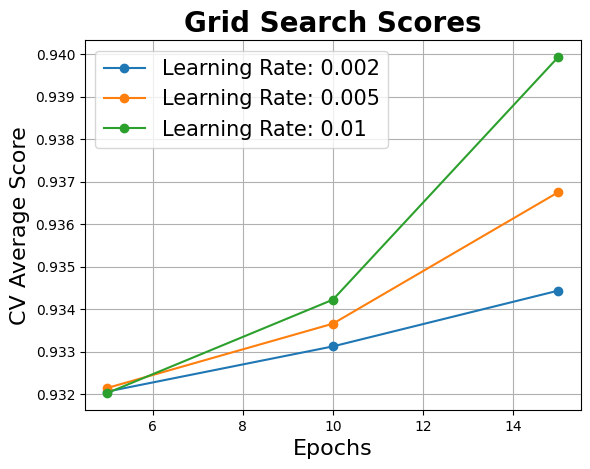

In [38]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_rmse']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_rmse']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

# Calling Method 
plot_grid_search(gs.cv_results, param_grid['n_epochs'], param_grid['lr_all'], 'Epochs', 'Learning Rate')

### 2.3.4. Final Model and Prediction

In [39]:
# Running the model with the best params that we just found above
svd_model = SVD(**gs.best_params['rmse'])

data = data.build_full_trainset()

svd_model.fit(data)

predictions = svd_model.test(testset)


In [40]:
# Now, we can try to predict the score of e.g. Blade Runner (movID = 541) for userID 1
svd_model.predict(uid=1.0, iid=541, verbose=True)

user: 1.0        item: 541        r_ui = None   est = 4.20   {'was_impossible': False}


Prediction(uid=1.0, iid=541, r_ui=None, est=4.198192035234815, details={'was_impossible': False})

In [41]:
# Taking a quick look at the user_movie_df, to see which movies certain users have and haven't rated
user_movie_df.head()

title,Blade Runner (1982),Cries and Whispers (Viskningar och rop) (1972),Forrest Gump (1994),The Dark Knight (2011)
userId,,,,
1.0,4.0,NaN,NaN,NaN
2.0,5.0,NaN,NaN,NaN
3.0,5.0,NaN,NaN,NaN
4.0,NaN,NaN,4.0,NaN
7.0,NaN,NaN,4.0,NaN


In [42]:
# Let's guess Blade Runner (movieID = 541) for userid 1
svd_model.predict(uid = 1.0, iid = 541, verbose = True) 
# uid = userID
# iid = itemID / movieID

user: 1.0        item: 541        r_ui = None   est = 4.20   {'was_impossible': False}


Prediction(uid=1.0, iid=541, r_ui=None, est=4.198192035234815, details={'was_impossible': False})

In [43]:
#  Cries and Whispers (356) for user id1.
svd_model.predict(uid=1.0, iid=356, verbose=True)

user: 1.0        item: 356        r_ui = None   est = 4.08   {'was_impossible': False}


Prediction(uid=1.0, iid=356, r_ui=None, est=4.080307571093203, details={'was_impossible': False})

This shows us, that the model predicts that the user will give Blade Runner a rating of 4.21 - a movie which the user in reality rated 4.0 (since the actual ratings are integers), so that is pretty good. If we then look at a movie which the user did not rate, Cries and Whispers, the model predicts that the user will give a rating of 4.04

If we apply this method for all the full data set, then we can fill out all of the missing values where users haven't rated movies with rating estimates predicted by our model. When we have the full dataset, we can then recommend the top movies for a specific user.

In [44]:
movies=pd.read_csv('movielens/movie.csv')
mapping = movies.set_index("movieId")["title"].to_dict()

In [45]:
true_ratings = [pred.r_ui for pred in predictions]
est_ratings = [pred.est for pred in predictions]
uids = [pred.uid for pred in predictions]

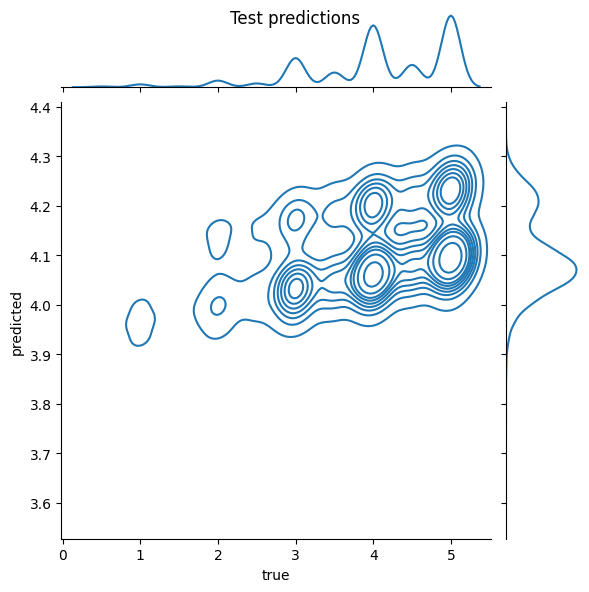

In [49]:
import seaborn as sns

data=pd.DataFrame(columns=["true","predicted"])
data["true"]=true_ratings
data["predicted"]=est_ratings
g = sns.jointplot(data=data,x="true", y="predicted", kind="kde",)
g.fig.suptitle('Test predictions',fontsize=12)
plt.show()

In [46]:
movies=pd.read_csv('movielens/movie.csv')
mapping = movies.set_index("movieId")["title"].to_dict()

users=list(set(uids))

In [51]:
import operator

# items which the user not yet evaluate
items = trainset.build_anti_testset()
for user in users[0:20]:
    user_items = list(filter(lambda x: x[0] == user, items))
    print()
    #print(user,len(user_items))
    # generate recommendation
    recommendations = svd_model.test(user_items)
    recommendations.sort(key=operator.itemgetter(3), reverse=True)
    print(f"User {user} recommendations:")
    for r in recommendations[0:5]:
        print(f"  Item {mapping[r[1]]} with estimated rating {r[3]}")


User 4.0 recommendations:

User 11.0 recommendations:
  Item Blade Runner (1982) with estimated rating 4.2569723950597815
  Item Cries and Whispers (Viskningar och rop) (1972) with estimated rating 3.9750471088013524

User 131085.0 recommendations:

User 131086.0 recommendations:
  Item Forrest Gump (1994) with estimated rating 3.974096347574087
  Item Cries and Whispers (Viskningar och rop) (1972) with estimated rating 3.9265648353936484

User 131087.0 recommendations:

User 14.0 recommendations:

User 131092.0 recommendations:
  Item Forrest Gump (1994) with estimated rating 4.124696695040521
  Item Cries and Whispers (Viskningar och rop) (1972) with estimated rating 4.059779835305618

User 131093.0 recommendations:

User 131102.0 recommendations:

User 35.0 recommendations:

User 131109.0 recommendations:
  Item Forrest Gump (1994) with estimated rating 4.123485101348623
  Item Cries and Whispers (Viskningar och rop) (1972) with estimated rating 4.0296692088804615

User 131110.0 re

<p><center>Acknowledgement to 'Comprehensive Guide to Build Recommendation Engine' by Devan Anjelito on Kaggle</center></p>